# Power Analysis for Adjusters

Unadjusted vs. adjusted conformal test martingale under a changepoint alternative

Two notions of statistical power are considered:
1. **Power of a test**: $$Q(\phi_t = 1),$$ where $\phi_t = 1(\mathfrak{e}_t \geq 1/\alpha)$.
2. **E-Power**: $$\mathbb{E}_Q[\log \mathfrak{e}_t].$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import ecombine as ec

In [2]:
# basic figure styles
ec.set_theme()

# rng for (randomized) inference methods
rng = np.random.default_rng(30105202)
# rng seed for data generator
rng_data_seed = 20250103

# plots saved here
plots_dir = "./plots/exch/power_analysis"
plot_fmt = "pdf"
os.makedirs(plots_dir, exist_ok=True)
mpl.rc("savefig", format=plot_fmt, dpi=350)

### Setup: Adjusted Conformal Test Martingale against a Changepoint Alternative

In [3]:
# max sequence length
T = 1000

# significance level
ALPHA = 0.1

# data rng
rng_data = np.random.default_rng(rng_data_seed)

In [4]:
n_repeats = 100    # number of repeated runs
errorbar = None

# conformal hyperparams
jump = 0.01
jumper_weights = (1/3, 1/3, 1/3)

### Changepoint Alternative (one "shock")

Conformal test martingales grow quickly against changepoint alternatives.

The following data has a changepoint from $Ber(p)$ to $Ber(q)$ after `0.2*T` (500) time steps, for a duration of `0.04*T` (100), before switching back to $Ber(p)$.

In [5]:
p, q = 0.5, 0.2
change_loc = 0.2
change_len = 0.04

# p, q = 0.5, 0.2
# change_loc = 0.15
# change_len = 0.05

x_change1 = ec.data.exch.generate_binary_changepoint(
    p=p, q=q, size=T, change_loc=change_loc, change_len=change_len,
    rng=rng_data)
x_change1[:10]

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 0])

In [6]:
change_every = 100
x_change_rep = ec.data.exch.generate_binary_change_repeated(
    p=p, q=q, size=T, change_every=100, rng=rng_data
)
x_change_rep

array([1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,

### Power of induced test at various significance levels

In [7]:
def run_power_experiment_changepoint(
        n_repeats,
        change_sizes=(0.0, 0.1, 0.2, 0.3, 0.4, 0.5),
        alpha=ALPHA,  # significance level
        data_config="repeated",  # "once", "twice"
        **conformal_kwargs
):
    """Run power experiment over repeated simulations."""

    full_df = []  # one df per run, combine at the end
    for change_size in change_sizes:
        p = 0.5 - change_size / 2
        q = 0.5 + change_size / 2
        # alternative config: 0.5 +/- change_size/2
        for i in range(n_repeats):
            # Generate data
            if data_config == "repeated":
                data = ec.data.exch.generate_binary_change_repeated(
                    p=p, q=q, size=T, change_every=change_every, rng=rng_data
                )
            elif data_config == "twice":
                data = ec.data.exch.generate_binary_change_twice(
                    p=p, q=q, size=T, rng=rng_data
                )
            else:
                data = ec.data.exch.generate_binary_changepoint(
                    p=p, q=q, size=T, change_loc=change_loc, change_len=change_len,
                    rng=rng_data,
                )
            # Compute unadjusted e-process
            eprocess = ec.eprocess_exch_conformal(data, **conformal_kwargs)

            # Adjust
            adj_eprocess = ec.adjuster(eprocess)

            # # Compute the rejection of a test at level alpha
            # power = np.maximum.accumulate(eprocess) >= (1 / alpha)

            # # Compute e-power
            # epower = np.log(eprocess)

            # Add as df
            full_df.append(pd.DataFrame({
                "ChangeSize": change_size,
                "RunID": i, 
                "Time": np.arange(1, T + 1),
                "Data": data,
                "Unadjusted": eprocess,
                "Adjusted": adj_eprocess,
                "UnadjustedPower": np.maximum.accumulate(eprocess) >= (1 / alpha),
                "AdjustedPower": np.maximum.accumulate(adj_eprocess) >= (1 / alpha),
                "UnadjustedEPower": np.log(eprocess),
                "AdjustedEPower": np.log(adj_eprocess),
            }))
        # Aggregate all experiment results
    full_df = pd.concat(full_df, axis=0)
    return full_df

In [8]:
conformal_kwargs = dict(
    jump=jump,
    jumper_weights=jumper_weights,
    rng=rng,
)

full_df = run_power_experiment_changepoint(
    n_repeats=100,
    change_sizes=(0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6),
    alpha=ALPHA,
    data_config="repeated",
    **conformal_kwargs
)
full_df

,ChangeSize,RunID,Time,Data,Unadjusted,Adjusted,UnadjustedPower,AdjustedPower,UnadjustedEPower,AdjustedEPower
0,0.0,0,1,0,1.000000e+00,5.000000e-01,False,False,0.000000e+00,-0.693147
1,0.0,0,2,1,1.000000e+00,5.000000e-01,False,False,-1.110223e-16,-0.693147
2,0.0,0,3,1,1.030856e+00,5.051036e-01,False,False,3.038938e-02,-0.682992
3,0.0,0,4,1,1.168278e+00,5.269619e-01,False,False,1.555310e-01,-0.640627
4,0.0,0,5,1,1.133027e+00,5.269619e-01,False,False,1.248931e-01,-0.640627
...,...,...,...,...,...,...,...,...,...,...
995,0.6,99,996,1,3.129493e+27,1.000000e+20,True,True,6.331067e+01,46.051702
996,0.6,99,997,1,3.595923e+27,1.000000e+20,True,True,6.344960e+01,46.051702
997,0.6,99,998,1,4.678434e+27,1.000000e+20,True,True,6.371276e+01,46.051702
998,0.6,99,999,1,6.684041e+27,1.000000e+20,True,True,6.406952e+01,46.051702


In [9]:
single_df = full_df.loc[full_df["ChangeSize"] == 0.2]
single_df

,ChangeSize,RunID,Time,Data,Unadjusted,Adjusted,UnadjustedPower,AdjustedPower,UnadjustedEPower,AdjustedEPower
0,0.2,0,1,1,1.000000,0.500000,False,False,0.000000e+00,-0.693147
1,0.2,0,2,0,1.000000,0.500000,False,False,-1.110223e-16,-0.693147
2,0.2,0,3,0,0.993192,0.500000,False,False,-6.830975e-03,-0.693147
3,0.2,0,4,0,0.999007,0.500000,False,False,-9.931853e-04,-0.693147
4,0.2,0,5,0,1.043594,0.507188,False,False,4.267027e-02,-0.678873
...,...,...,...,...,...,...,...,...,...,...
995,0.2,99,996,0,41.013345,18.968131,True,True,3.713898e+00,2.942760
996,0.2,99,997,1,42.344918,18.968131,True,True,3.745848e+00,2.942760
997,0.2,99,998,0,40.457929,18.968131,True,True,3.700263e+00,2.942760
998,0.2,99,999,1,40.813159,18.968131,True,True,3.709005e+00,2.942760


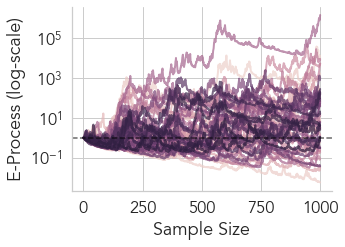

In [10]:
# Plot the first K e-processes
fg = sns.relplot(
    x="Time",
    y="Unadjusted",
    kind="line",
    hue="RunID",
    aspect=1.25,
    height=4,
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=single_df.loc[single_df["RunID"] <= 50],
    legend=None,
)
fg.ax.set(
    xlabel="Sample Size",
    ylabel="E-Process (log-scale)",
    yscale="log",
)
fg.ax.axhline(y=1, color="black", alpha=0.6, linestyle="dashed")
None

### vs. Sample Size

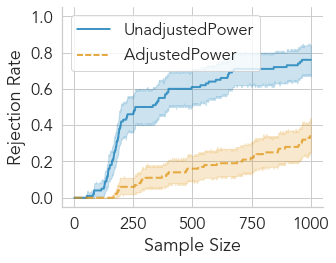

In [11]:
# Power
power_df = single_df.melt(
    id_vars=["RunID", "Time"], value_vars=["UnadjustedPower", "AdjustedPower"],
    var_name="E-Process", value_name="Power")
power_df["E-Process"].rename({"UnadjustedPower": "Unadjusted", 
                              "AdjustedPower": "Adjusted"}, inplace=True)
fg = sns.relplot(
    x="Time",
    y="Power",
    hue="E-Process",
    style="E-Process",
    kind="line",
    # markers=True,
    errorbar="ci",
    aspect=1.25,
    height=4,
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=power_df,
    facet_kws=dict(legend_out=False),
)
fg._legend.set_title(None)
fg.ax.set(
    ylim=(-0.05, 1.05),
    ylabel="Rejection Rate",
    xlabel="Sample Size",
)
None

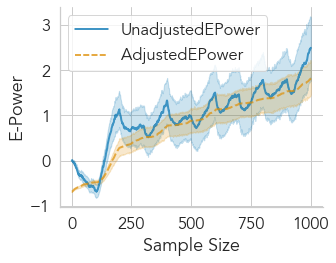

In [12]:
# E-Power
epower_df = single_df.melt(
    id_vars=["RunID", "Time"], value_vars=["UnadjustedEPower", "AdjustedEPower"],
    var_name="E-Process", value_name="E-Power")
epower_df["E-Process"].rename({"UnadjustedEPower": "Unadjusted", 
                               "AdjustedEPower": "Adjusted"}, inplace=True)
fg = sns.relplot(
    x="Time",
    y="E-Power",
    hue="E-Process",
    style="E-Process",
    kind="line",
    # markers=True,
    errorbar="ci",
    aspect=1.25,
    height=4,
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=epower_df,
    facet_kws=dict(legend_out=False),
)
fg._legend.set_title(None)
fg.ax.set(
    # ylim=(-0.05, 1.05),
    ylabel="E-Power",
    xlabel="Sample Size",
)
None

### vs. Change Size

We "collapse" the sample size dimension by looking at whether a test was rejected within the 1000 steps.


In [13]:
idf = full_df.query("ChangeSize == 0.8 and RunID == 0")
idf

,ChangeSize,RunID,Time,Data,Unadjusted,Adjusted,UnadjustedPower,AdjustedPower,UnadjustedEPower,AdjustedEPower


In [14]:
collapsed_df = []
for change_size in full_df.ChangeSize.unique():
    for run_id in full_df.RunID.unique():
        idf = full_df.query(f"ChangeSize == {change_size} and RunID == {run_id}")
        # print(change_size, run_id, idf.shape)
        unadj_reject_any = idf["Unadjusted"].any()
        unadj_reject_time = idf["Unadjusted"].argmax() if unadj_reject_any else T
        unadj_e = idf["Unadjusted"].max()
        adj_reject_any = idf["Adjusted"].any()
        adj_reject_time = idf["Adjusted"].argmax() if adj_reject_any else T
        adj_e = idf["Adjusted"].max()
        collapsed_df.append({
            "ChangeSize": change_size,
            "RunID": run_id,
            "Unadjusted": unadj_e,
            "UnadjustedPower": unadj_e >= (1 / ALPHA),
            "UnadjustedRejectionTime": unadj_reject_time,
            "Adjusted": adj_e,
            "AdjustedPower": adj_e >= (1 / ALPHA),
            "AdjustedRejectionTime": adj_reject_time,
        })
collapsed_df = pd.DataFrame(collapsed_df)
collapsed_df

,ChangeSize,RunID,Unadjusted,UnadjustedPower,UnadjustedRejectionTime,Adjusted,AdjustedPower,AdjustedRejectionTime
0,0.0,0,4.411155e+00,False,38,8.748592e-01,False,38
1,0.0,1,1.256412e+00,False,131,5.403172e-01,False,131
2,0.0,2,2.275854e+00,False,41,6.705897e-01,False,41
3,0.0,3,2.201258e+00,False,66,6.621442e-01,False,66
4,0.0,4,1.800101e+00,False,29,6.142457e-01,False,29
...,...,...,...,...,...,...,...,...
695,0.6,95,1.490703e+35,True,999,1.000000e+20,True,578
696,0.6,96,1.065403e+32,True,979,1.000000e+20,True,762
697,0.6,97,2.850762e+31,True,999,1.000000e+20,True,782
698,0.6,98,9.872489e+32,True,998,1.000000e+20,True,786


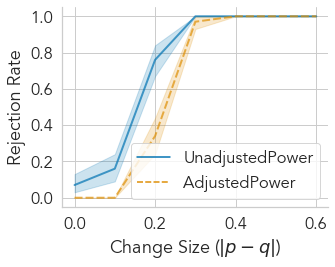

In [15]:
# Power vs. ChangeSize
power_change_df = collapsed_df.melt(
    id_vars=["ChangeSize", "RunID"],
    value_vars=["UnadjustedPower", "AdjustedPower"],
    var_name="E-Process", value_name="Power"
)
fg = sns.relplot(
    x="ChangeSize",
    y="Power",
    hue="E-Process",
    style="E-Process",
    kind="line",
    # markers=True,
    errorbar="ci",
    aspect=1.25,
    height=4,
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=power_change_df,
    facet_kws=dict(legend_out=False),
)
fg._legend.set_title(None)
fg.ax.set(
    # ylim=(-0.05, 1.05),
    ylabel="Rejection Rate",
    xlabel=r"Change Size ($|p-q|$)",
)
None

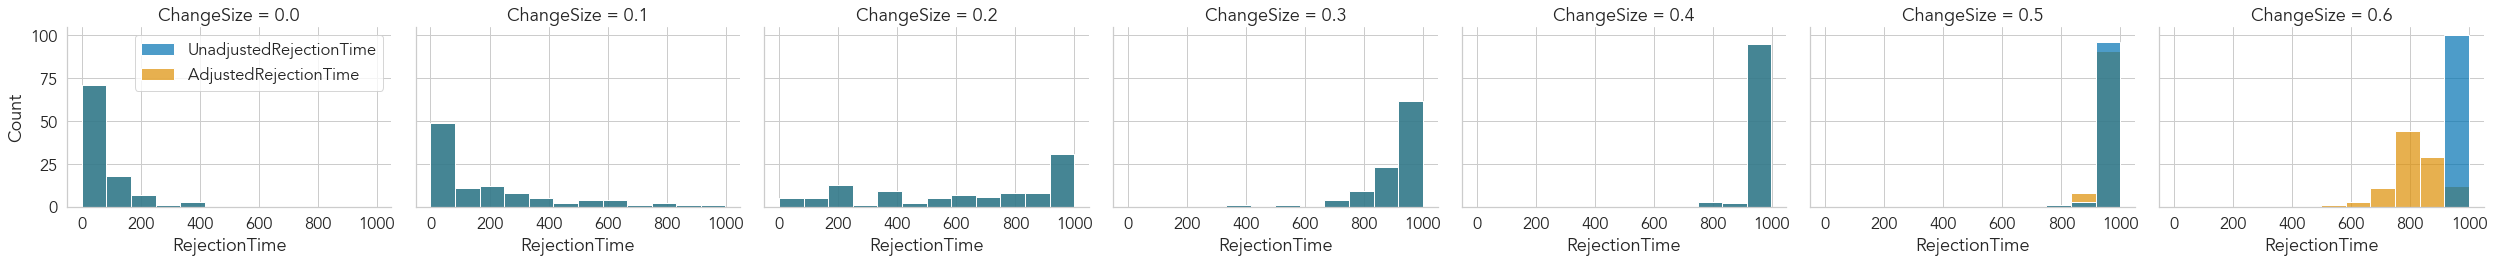

In [16]:
# Rejection Times Histogram
rejection_time_df = collapsed_df.melt(
    id_vars=["ChangeSize", "RunID"],
    value_vars=["UnadjustedRejectionTime", "AdjustedRejectionTime"],
    var_name="E-Process", value_name="RejectionTime"
)

# Rejection Times vs. ChangeSize
fg = sns.displot(
    x="RejectionTime",
    col="ChangeSize",
    hue="E-Process",
    kind="hist",
    aspect=1.25,
    height=4,
    # linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=rejection_time_df,
    facet_kws=dict(legend_out=False),
)
fg._legend.set_title(None)
# fg.ax.set(
#     # ylim=(-0.05, 1.05),
#     ylabel="Rejection Time",
#     xlabel=r"Change Size ($|p-q|$)",
# )
None

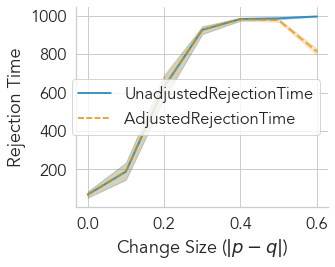

In [17]:
# Rejection Times vs. ChangeSize
fg = sns.relplot(
    x="ChangeSize",
    y="RejectionTime",
    hue="E-Process",
    style="E-Process",
    kind="line",
    # markers=True,
    errorbar="ci",
    aspect=1.25,
    height=4,
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    data=rejection_time_df,
    facet_kws=dict(legend_out=False),
)
fg._legend.set_title(None)
fg.ax.set(
    # ylim=(-0.05, 1.05),
    ylabel="Rejection Time",
    xlabel=r"Change Size ($|p-q|$)",
)
None

In [18]:
collapsed_df = full_df.groupby(
    by=["ChangeSize", "RunID"],
).agg({"UnadjustedPower": "max", "AdjustedPower": "max"})
collapsed_df

UnadjustedPower  AdjustedPower
ChangeSize RunID                                
0.0        0                False          False
           1                False          False
           2                False          False
           3                False          False
           4                False          False
...                           ...            ...
0.6        95                True           True
           96                True           True
           97                True           True
           98                True           True
           99                True           True

[700 rows x 2 columns]

In [19]:
collapsed_df.groupby(by="ChangeSize").agg(["mean", "sem"])

UnadjustedPower           AdjustedPower          
                      mean       sem          mean       sem
ChangeSize                                                  
0.0                   0.07  0.025643          0.00  0.000000
0.1                   0.16  0.036845          0.00  0.000000
0.2                   0.76  0.042923          0.34  0.047610
0.3                   1.00  0.000000          0.97  0.017145
0.4                   1.00  0.000000          1.00  0.000000
0.5                   1.00  0.000000          1.00  0.000000
0.6                   1.00  0.000000          1.00  0.000000